## Loading datasets

In [1]:
import os

import torch
import torch.nn.functional as F
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from utils.dataset import TrainDataset
from utils.mask import tensor_arr_dist_circle_mask, tensor_img_dist_circle_mask, tensor_img_px_circle_mask, get_tensor_img_px_circle_mask_rgb
from utils.optical_flow.spynet import spynet_optical_flow 
from utils.optical_flow.farneback import farneback_optical_flow
from utils.visualization import show_imgs, show_farneback_optical_flows, save_spynet_optical_flows
from utils.pose import get_circular_poses

# Dataset and Loader
dataset_test = TrainDataset(
    [[os.path.join('data/same_vis_same_phys/train/', fp) for fp in os.listdir('data/same_vis_same_phys/train/')][1]],
    batch_size_per_gpu=1,
    img_size=(256, 256),
    buffer_size=3)
 
loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    num_workers=4,
    collate_fn = (lambda x: x),
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

# buffer samples: 55


### Extract integers

In [2]:
def extract_integers(filename):
    split_list = filename.split('.')[0].split('_') 
    int1 = split_list[1]
    int2 = split_list[3]
    return int(f'{int1}{int2}')

def extract_integer(filename):
    return int(filename.split('.')[0].split('_')[1])


def check_list(input_list):
    for buffer_idx, buffer in enumerate(input_list):
        previous_timestep = -1
        for timestep_file in buffer:
            file_parts = timestep_file.split('_')
            current_buffer = int(file_parts[1])
            current_timestep = int(file_parts[3].split('.')[0])

            if current_buffer != buffer_idx or current_timestep != previous_timestep + 1:
                return False

            previous_timestep = current_timestep

    return True


sample_list = [['buffer_0_timestep_0.png', 'buffer_0_timestep_1.png', 'buffer_0_timestep_2.png'],
               ['buffer_1_timestep_0.png', 'buffer_1_timestep_1.png', 'buffer_1_timestep_-1.png'],
               ['buffer_2_timestep_0.png', 'buffer_2_timestep_1.png', 'buffer_2_timestep_2.png']]

result = check_list(sample_list)

### Mean color

55
tensor([0.4401, 0.5570, 0.7492])


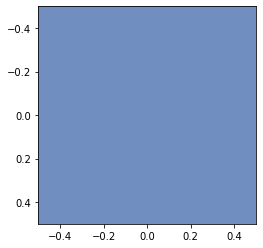

In [3]:
# get an example
output = iterator_train.next()
output = output[0]['img_data'][0]

p0 = get_circular_poses(output[0]).numpy()

rgb_values = get_tensor_img_px_circle_mask_rgb(output[0], p0[0,0], p0[0,1], p0[0,2])
print(len(rgb_values))
mean_rgb = rgb_values.mean(axis=0) 
print(mean_rgb)
plt.imshow([[tuple(mean_rgb.numpy())]])

### Multi-Object Tracking

236.12279 121.39987 4.35496


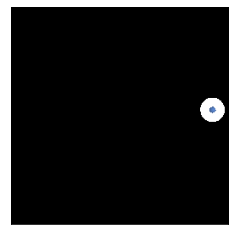

175.32233 53.283646 4.206762


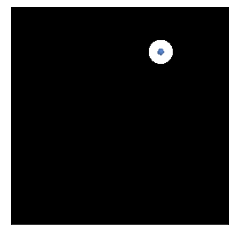

156.98427 26.491158 4.3862276


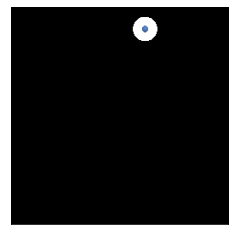

238.15836 118.14292 4.35496


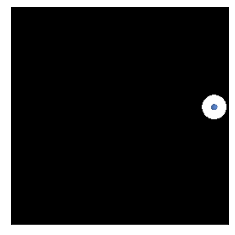

177.10324 55.090855 4.206762


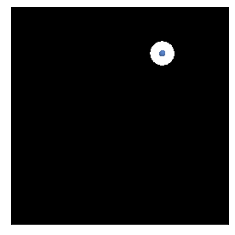

160.79115 28.903587 4.3862276


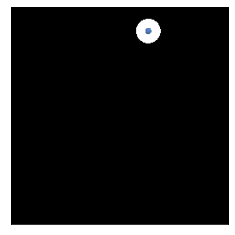

In [4]:
# get an example
output = iterator_train.next()
output = output[0]['img_data'][0]

p0= get_circular_poses(output[0]).numpy()

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

for i in range(len(output)-1):
    opt_flow = farneback_optical_flow(output[i], output[i+1])
    p1 = []
    for keypoint in p0:
        x, y = keypoint[0], keypoint[1]
        x += opt_flow[0,int(y), int(x)].numpy()
        y += opt_flow[1,int(y), int(x)].numpy()
        p1.append([x, y, keypoint[2]])
        print(x,y,keypoint[2])
        show_imgs([tensor_img_px_circle_mask(output[i+1], x, y, keypoint[2]+10)])
    
    p0 = p1

## Metres to pixel based masking

In [5]:
# px_per_m calculation
q = 55.0 * np.pi / 180
focal_length = 256.0 / np.tan(q/2)
px_per_m = focal_length * 1/2
m_per_px = 1 / px_per_m

In [6]:
# backtracking 256 px_per_m to q
focal_length = 2 * 256
q = np.arctan(256.0 / focal_length) * 2 * 180 / np.pi

## Testing images and optical flow

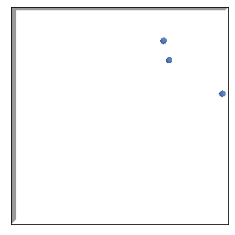

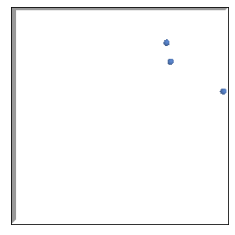

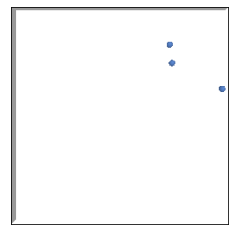

In [7]:
output = iterator_train.next()
for i in range(len(output[0]['img_data'][0])):
    show_imgs([output[0]['img_data'][0,i]])

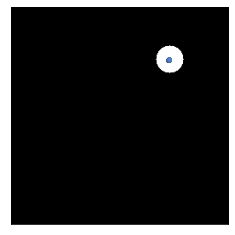

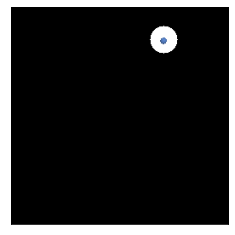

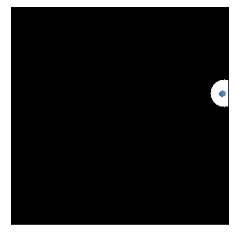

In [8]:
for cx,cy,cr in output[0]['state_label'][0][0][:, [0,1,-2]].detach().numpy():
    show_imgs([tensor_img_dist_circle_mask(output[0]['img_data'][0, 0], cx, cy, cr + 0.05)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.4590,  0.5105,  0.3932, -0.3925,  0.0300,  6.0000],
        [ 0.4053,  0.6939,  0.8605, -0.5513,  0.0300,  6.0000],
        [ 0.9600,  0.1954,  0.4692,  0.7521,  0.0300,  6.0000]])
(2, 256, 256)


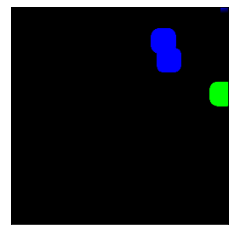

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


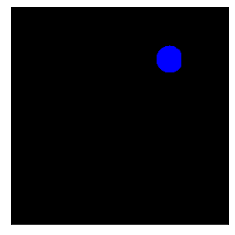

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


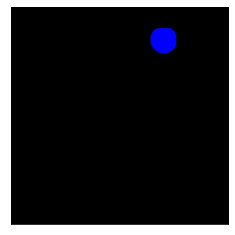

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


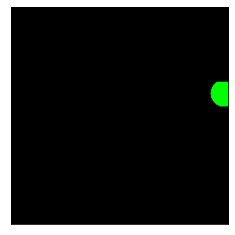

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


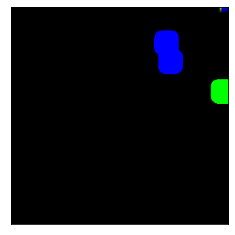

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


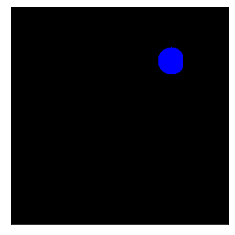

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


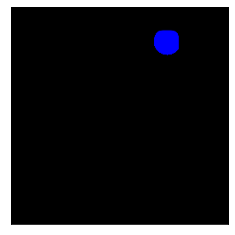

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 256, 256)


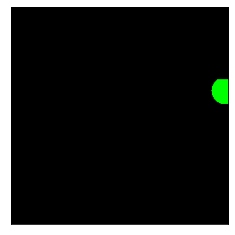

In [9]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

print(output[0]['state_label'][0][0])
for i in range(2):
    opt_flow = farneback_optical_flow(output[0]['img_data'][0][i], output[0]['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output[0]['state_label'][0][i][j, 0]
        cy = output[0]['state_label'][0][i][j, 1]
        cr = output[0]['state_label'][0][i][j, -2]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

for i in range(len(opt_flow_masks)):
    show_farneback_optical_flows([opt_flow_masks[i]])

In [10]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = spynet_optical_flow(output[0]['img_data'][0][i], output[0]['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output[0]['state_label'][0][i][j, 0]
        cy = output[0]['state_label'][0][i][j, 1]
        cr = output[0]['state_label'][0][i][j, -1]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

#save_spynet_optical_flows(opt_flow_masks)

In [11]:
input_data = output[0]['img_data']
output_data = output[0]['state_label']

BA, BU, C, H, W = input_data.shape
_, _, num_balls, num_features = output_data.shape
processed_output_data = output_data

C_Final = BU * 3 + (BU - 1) * 2
input_processed = torch.zeros(BA, num_balls, C_Final, H, W)
assert BU == 3
for i in range(BA):
    for j in range(BU):
        img_orig = input_data[i, j, ...]
        for k in range(num_balls):
            cx, cy, cr = output_data[i, j, k, [0, 1, -2]]
            img_masked = tensor_img_dist_circle_mask(img_orig, cx, cy, cr+0.05)
            input_processed[i, k, j * 3:(j + 1) * 3, ...] = img_masked
            if j != BU-1:
                opt_flow = farneback_optical_flow(input_data[i][j], input_data[i][j+1])
                opt_flow_masked = tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1)
                input_processed[i, k, BU*3 + j*2:BU*3 + (j+1)*2, ...] = opt_flow_masked
input_processed = torch.flatten(input_processed, end_dim=1)

In [12]:
#input_processed = input_processed.view(-1, num_balls, C_Final, H, W)
#for i in range(BA):
   #print(f'batch {i}')
   #for k in range(num_balls):
       #print(f'ball {k}')
       #for j in range(BU):
           #print(f'buffer {j}')
           #masked_img = input_processed[i,k, j * 3:(j + 1) * 3, ...]
           #show_imgs([masked_img])
           #if j != BU-1:
           #    opt_flow_masked = input_processed[i + k, BU*3 + j*2:BU*3 + (j+1)*2]
           #    show_farneback_optical_flows([opt_flow_masked])

### labelling function

In [13]:
label = torch.zeros(1000, dtype=torch.long)
label[:] = 0

output = torch.rand(1000,9)

pred_log_prob = F.log_softmax(output, dim=1)
preds = torch.argmax(output, dim=1)
valid = (label >= 0).long()
acc_sum = torch.sum(valid * (preds == label).long())
valid_sum = torch.sum(valid)
acc = acc_sum.float() / (valid_sum.float() + 1e-10)
#print(label)
#print(preds)
print(acc)

tensor(0.1060)


### Dataset indexing function

In [14]:
def idx2idxs(idx, arr):
    if all(len(arr[0]) == len(x) for x in arr):
        shape = [len(arr), len(arr[0])]
        num_dims = len(shape)
        offset = 1
        idxs = [0] * num_dims
        for i in range(num_dims - 1, -1, -1):
            idxs[i] = idx // offset % shape[i]
            offset *= shape[i]
    else:
        count = 0
        for i in range(len(arr)):
            if count + len(arr[i]) > idx:
                idxs = [i, idx - count]
                break
            count += len(arr[i])
    return tuple(idxs)

In [15]:
idx = 1999
A = np.arange(1000).reshape((8,-1))
B = np.arange(1000, 2000).reshape((5,-1))
C = list(A) + list(B)
i,j = idx2idxs(idx, C)
print(i,j)
print(C[i][j])

12 199
1999


In [16]:
output.shape

torch.Size([1000, 9])

In [17]:
output = iterator_train.next()
for i in range(2):
    opt_flow = farneback_optical_flow(output[0]['img_data'][0][i], output[0]['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        opt_flow_masks.append(opt_flow)
        
img1 = cv2.cvtColor(output[0]['img_data'][0][0].permute(1, 2, 0).numpy(), cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(output[0]['img_data'][0][1].permute(1, 2, 0).numpy(), cv2.COLOR_RGB2GRAY)

opt_flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
opt_flow = opt_flow.transpose((2, 0, 1))
opt_flow = torch.from_numpy(opt_flow.copy())